### Inference with SportsBERT
  
*Gian Favero and Michael Montemurri, Mila, 2024*


The xPassRush dataframe contains all play + player data from each game. This block of code merges all defensive players for a given play into one row, where players are identified by position and suffixed by the number.

In [ ]:
# Load dataframe
import pandas as pd

df = pd.read_csv('../data/processed/df_xPassRus_garabgeTime.csv')

# Filter for defensive players only
defensive_players = df[df["club"] != df["possessionTeam"]].copy()

# Add a unique identifier for each position within a play
defensive_players["positionCount"] = (
    defensive_players.groupby(["gameId", "playId", "position"]).cumcount() + 1
)

# Create a unique column suffix for each player using their position
defensive_players["playerSuffix"] = defensive_players["position"] + defensive_players["positionCount"].astype(str)

# Pivot the defensive player hDist and losDist data
pivoted = defensive_players.pivot_table(
    index=["gameId", "playId"],
    columns="playerSuffix",
    values=["xPassRush"],
    aggfunc="first"
)

# Flatten the multi-level columns for easier readability
pivoted.columns = [f"{metric}_{suffix}" for metric, suffix in pivoted.columns]

# Reset index to merge with game context
pivoted.reset_index(inplace=True)

# Extract game context (assuming it doesn't vary within a play)
game_context = defensive_players.drop_duplicates(subset=["gameId", "playId"])

# Merge pivoted data with game context
result_df = pd.merge(game_context, pivoted, on=["gameId", "playId"], how="left")

       gameId  playId homeTeamAbbr visitorTeamAbbr  frameId  nflId  \
0  2022090800      56           LA             BUF       76  38577   
1  2022090800      80           LA             BUF       23  38577   
2  2022090800     101           LA             BUF       46  38577   
3  2022090800     122           LA             BUF       78  38577   
4  2022090800     167           LA             BUF       75  38577   

    displayName position club  down  ...  xPassRush_ILB4  xPassRush_OLB1  \
0  Bobby Wagner      ILB   LA     1  ...             NaN             NaN   
1  Bobby Wagner      ILB   LA     2  ...             NaN             NaN   
2  Bobby Wagner      ILB   LA     1  ...             NaN        0.834283   
3  Bobby Wagner      ILB   LA     2  ...             NaN        0.895475   
4  Bobby Wagner      ILB   LA     2  ...             NaN        0.900457   

  xPassRush_OLB2 xPassRush_OLB3 xPassRush_OLB4  xPassRush_S1 xPassRush_S2  \
0            NaN            NaN            Na

Some additional data processing can occur here. Plays where the QB was sacked has no determinable outcome in terms of what the original play call was. As such, this should be excluded from the training data since it could have really been anything, and leaving it empty can allow the model to latch onto this to predict less yards gained.

In [ ]:
# Reduce the size of the dataframe by removing unnecessary columns
game_context_columns = [
        "gameId",
        "playId",
        "homeTeamAbbr",
        "visitorTeamAbbr",
        "frameId",
        "nflId",
        "displayName",
        "position",
        "club",
        "down",
        "quarter",
        "yardsToGo",
        "possessionTeam",
        "defensiveTeam",
        "yardlineSide",
        "yardlineNumber",
        "gameClock",
        "preSnapHomeScore",
        "preSnapVisitorScore",
        "preSnapHomeTeamWinProbability",
        "preSnapVisitorTeamWinProbability",
        "event",
    ]

# Offensive formation, receiver alignment, and pre-snap win probabilities related to OC
offense_columns = [
        "offenseFormation",
        "receiverAlignment",
    ]

# Defensive formation, pass coverage, and run concept related to DC
defensive_columns = [
        "pff_manZone",
        "pff_passCoverage",
        "xPassRush"
]
defensive_columns = [col for col in result_df.columns if any(prefix in col for prefix in defensive_columns)]
defensive_columns.remove('xPassRush')

# Play description, pass location, rush location, and PFF run concept related to play call
play_columns = [
        "playDescription",
        "playAction",
        "passLocationType",
        "rushLocationType",
        "pff_runConceptPrimary",
    ]

# Run play mappings (combine common run concepts)
run_concept_mapping = {
    "outside zone": "zone",
    "inside zone": "zone",
    "pull lead": "power",
    "power": "power",
    "man": "power",
    "trap": "power",
    "counter": "misdirection",
    "draw": "misdirection",
    "fb run": "power",
    "trick": "trick",
    "undefined": "undefined",
}

# Yards gained, event, and win probability added related to play outcome
outcome_columns = [
        "yardsGained",
        "homeTeamWinProbabilityAdded",
        "visitorTeamWinProbilityAdded",
    ]

# Combine all columns
useful_columns = game_context_columns + offense_columns + defensive_columns + play_columns + outcome_columns

df_reduced = result_df[useful_columns].copy()

# Remove plays where the QB was sacked
df_reduced = df_reduced[~df_reduced["playDescription"].str.contains("sacked")]

We can define functions to extract the relevant information from each row in the dataframe and form sentence prompts for a BERT model.

In [ ]:
def remove_spaces(text):
    # Remove leading and trailing spaces and double spaces
    return " ".join(text.split())

def get_game_context(game_context):
    quarter = game_context["quarter"].values[0] if not pd.isna(game_context["quarter"].values[0]) else "N/A"
    down = game_context["down"].values[0] if not pd.isna(game_context["down"].values[0]) else "N/A"
    yards_to_go = game_context["yardsToGo"].values[0] if not pd.isna(game_context["yardsToGo"].values[0]) else "N/A"
    yardline_number = game_context["yardlineNumber"].values[0] if not pd.isna(game_context["yardlineNumber"].values[0]) else "N/A"
    yardline_side = game_context["yardlineSide"].values[0] if not pd.isna(game_context["yardlineSide"].values[0]) else "N/A"
    game_clock = game_context["gameClock"].values[0] if not pd.isna(game_context["gameClock"].values[0]) else "N/A"
    pre_snap_home_score = game_context["preSnapHomeScore"].values[0] if not pd.isna(game_context["preSnapHomeScore"].values[0]) else "N/A"
    pre_snap_visitor_score = game_context["preSnapVisitorScore"].values[0] if not pd.isna(game_context["preSnapVisitorScore"].values[0]) else "N/A"

    home_team_abbr = game_context["homeTeamAbbr"].values[0] if not pd.isna(game_context["homeTeamAbbr"].values[0]) else "N/A"
    visitor_team_abbr = game_context["visitorTeamAbbr"].values[0] if not pd.isna(game_context["visitorTeamAbbr"].values[0]) else "N/A"
    possession_team = game_context["possessionTeam"].values[0] if not pd.isna(game_context["possessionTeam"].values[0]) else "N/A"

    pre_snap_home_team_win_probability = game_context["preSnapHomeTeamWinProbability"].values[0] if not pd.isna(game_context["preSnapHomeTeamWinProbability"].values[0]) else "N/A"
    pre_snap_visitor_team_win_probability = game_context["preSnapVisitorTeamWinProbability"].values[0] if not pd.isna(game_context["preSnapVisitorTeamWinProbability"].values[0]) else "N/A"

    ret_str = f"It is {quarter} quarter with {game_clock} left. It is {down} down with {yards_to_go} yards to go. The ball is on the {yardline_side} {yardline_number} yardline. The score is {home_team_abbr} {pre_snap_home_score} - {visitor_team_abbr} {pre_snap_visitor_score}. {possession_team} have the ball. Current win probability for {home_team_abbr} is {pre_snap_home_team_win_probability:.2f} and for {visitor_team_abbr} it is {pre_snap_visitor_team_win_probability:.2f}."

    return ret_str

def get_offensive_context(offense_context):
    offense_formation = offense_context["offenseFormation"].values[0] if not pd.isna(offense_context["offenseFormation"].values[0]) else "N/A"
    receiver_alignment = offense_context["receiverAlignment"].values[0] if not pd.isna(offense_context["receiverAlignment"].values[0]) else "N/A"

    # Remove underscores and lowercase the text
    offense_formation = offense_formation.lower().replace("_", " ")
    receiver_alignment = receiver_alignment.lower().replace("_", " ")

    ret_str = f"The offense is in {offense_formation} formation with the receivers aligned in {receiver_alignment}."

    return ret_str

def get_defensive_context(defensive_context):
    defensive_formation = defensive_context["pff_manZone"].values[0] if not pd.isna(defensive_context["pff_manZone"].values[0]) else "N/A"
    pass_coverage = defensive_context["pff_passCoverage"].values[0] if not pd.isna(defensive_context["pff_passCoverage"].values[0]) else "N/A"

    # Remove underscores and lowercase the text
    defensive_formation = defensive_formation.lower().replace("_", " ")
    pass_coverage = pass_coverage.lower().replace("_", " ")

    ret_str = f"The defense is in {defensive_formation} coverage with {pass_coverage} formation."

    return ret_str

def get_blitzer(defensive_context):
    # check all columns prefixed with xPassRush
    rushers = { 'CB': 0, 'S': 0, 'ILB': 0, 'OLB': 0, 'DE': 0, 'IDL': 0 }
    for col in defensive_context.columns:
        if "xPassRush" in col:
            xPassRush = defensive_context[col].values[0] if not pd.isna(defensive_context[col].values[0]) else 0
            if xPassRush > 0.2:
                # split the column name to get the position
                position = col.split("_")[1]
                position = position[:-1] if position[-1].isdigit() else position
                rushers[position] += 1
    ret_str = f"The defense is rushing {rushers['CB']} cornerbacks, {rushers['S']} safeties, {rushers['ILB']} inside linebackers, {rushers['OLB']} outside linebackers, {rushers['DE']} defensive ends, and {rushers['IDL']} interior defensive linemen."
    return ret_str

def get_play_description(play_context):
    # Replace NaN with a placeholder or handle it explicitly
    playAction = play_context["playAction"].values[0] if not pd.isna(play_context["playAction"].values[0]) else "N/A"
    passLocationType = play_context["passLocationType"].values[0] if not pd.isna(play_context["passLocationType"].values[0]) else "N/A"
    rushLocationType = play_context["rushLocationType"].values[0] if not pd.isna(play_context["rushLocationType"].values[0]) else "N/A"
    pff_runConceptPrimary = play_context["pff_runConceptPrimary"].values[0] if not pd.isna(play_context["pff_runConceptPrimary"].values[0]) else ""
    playDescription = play_context["playDescription"].values[0] if not pd.isna(play_context["playDescription"].values[0]) else ""

    if passLocationType != "N/A":
        passLocationType = passLocationType.lower().replace("_", " ").split(" ")[0] + " box"

        # Get the direction and depth from the play description
        passDepth = "short" if "short" in playDescription else "deep" if "deep" in playDescription else ""
        passDirection = "left" if "left" in playDescription else "right" if "right" in playDescription else "middle"

        # In case of a disagreement in passDirection and passLocationType, use the passDirection from the play description
        if passDirection == "middle" and passLocationType != "inside box":
            passLocationType = "inside box"

        if playAction:
            ret_val = f"play action {passDepth} {passLocationType} pass"
        else:
            ret_val = f"{passDepth} {passLocationType} pass"
    else:
        pff_runConceptPrimary = pff_runConceptPrimary.lower().replace("_", " ")
        # Simplify the run concept
        if pff_runConceptPrimary in run_concept_mapping:
            pff_runConceptPrimary = run_concept_mapping[pff_runConceptPrimary]
        rushLocationType = rushLocationType.lower().replace("_", " ")
        ret_val = f"{pff_runConceptPrimary} run"

    ret_val = "The offense play call is a " + ret_val + "."

    return remove_spaces(ret_val)

def get_xWinProb_outcome(outcome_context):
    home_team_abbr = outcome_context["homeTeamAbbr"].values[0] if not pd.isna(outcome_context["homeTeamAbbr"].values[0]) else "N/A"
    visitor_team_abbr = outcome_context["visitorTeamAbbr"].values[0] if not pd.isna(outcome_context["visitorTeamAbbr"].values[0]) else "N/A"
    possession_team = outcome_context["possessionTeam"].values[0] if not pd.isna(outcome_context["possessionTeam"].values[0]) else "N/A"
    yards_gained = outcome_context["yardsGained"].values[0] if not pd.isna(outcome_context["yardsGained"].values[0]) else "N/A"
    home_team_win_probability_added = outcome_context["homeTeamWinProbabilityAdded"].values[0] if not pd.isna(outcome_context["homeTeamWinProbabilityAdded"].values[0]) else "N/A"
    visitor_team_win_probability_added = outcome_context["visitorTeamWinProbilityAdded"].values[0] if not pd.isna(outcome_context["visitorTeamWinProbilityAdded"].values[0]) else "N/A"

    # Find out if the possession team is the home or visitor team
    if possession_team == home_team_abbr:
        win_probability_added = home_team_win_probability_added
    else:
        win_probability_added = visitor_team_win_probability_added

    return win_probability_added

def get_xYardsGained_outcome(outcome_context):
    yards_gained = outcome_context["yardsGained"].values[0] if not pd.isna(outcome_context["yardsGained"].values[0]) else "N/A"

    return yards_gained

In [ ]:
#creating a list of the unique play calls

simple_play_calls = ['The offense play call is a short inside box pass.', 'The offense play call is a run.', 'The offense play call is a zone run.', 'The offense play call is a power run.', 'The offense play call is a short outside box pass.', 'The offense play call is a play action short outside box pass.', 'The offense play call is a deep outside box pass.', 'The offense play call is a play action short inside box pass.', 'The offense play call is a deep inside box pass.', 'The offense play call is a misdirection run.', 'The offense play call is a trick run.', 'The offense play call is a play action deep outside box pass.', 'The offense play call is a play action deep inside box pass.', 'The offense play call is a undefined run.', 'The offense play call is a inside box pass.']


In [ ]:
# Take sample play
sample_play = df_reduced.iloc[[64]]

# Extract the game context using the game_context_columns
game_context = sample_play[game_context_columns]

# Extract the offensive formation, receiver alignment, and pre-snap win probabilities using the offense_columns
offense_context = sample_play[offense_columns]

# Extract the defensive formation, pass coverage, and pass rush using the defensive_columns
defense_context = sample_play[defensive_columns]

# Extract the play description, play action, pass location, rush location, and run concept using the play_columns
play_context = sample_play[play_columns]

# Extract the yards gained, event, and win probability added using the outcome_columns
outcome_columns += ["homeTeamAbbr", "visitorTeamAbbr", "possessionTeam"]
outcome_context = sample_play[outcome_columns]

# Get the prompts for each of the rows in the dataframe
prompts = []
labels = []
desired_label = "yardsGained"

counter_factual_prompts = []
for i in range(len(sample_play)):
    row = sample_play.iloc[[i]]

    game_context_str = get_game_context(row[game_context_columns])
    offensive_context_str = get_offensive_context(row[offense_columns])
    defensive_context_str = get_defensive_context(row[defensive_columns])
    blitzer_str = get_blitzer(row[defensive_columns])
    simple_play_call = get_play_description(row[play_columns])

    prompt = f"Play {i + 1}: {game_context_str} {offensive_context_str} {defensive_context_str} {blitzer_str} {simple_play_call}"
    prompts.append(prompt)

    if i==0:
      for play in simple_play_calls:
         counter_factual_prompt = f"Play {i + 1}: {game_context_str} {offensive_context_str} {defensive_context_str} {blitzer_str} {play}"
         counter_factual_prompts.append(counter_factual_prompt)

    win_probability_added = get_xWinProb_outcome(row[outcome_columns])
    yards_gained = get_xYardsGained_outcome(row[outcome_columns])

    if desired_label == "winProbabilityAdded":
        labels.append(round(win_probability_added, 4))
    else:
        labels.append(round(yards_gained, 4))

In [ ]:
# filtered_rows = df_reduced[df_reduced['yardsGained'] == 7].head(10)

# # Print the gameId, playId, and index of those rows
# for index, row in df_reduced.iterrows():
#     if row['yardsGained'] == 7:
#       print(f"Index: {index}, gameId: {row['gameId']}, playId: {row['playId']}, yardsGained: {row['yardsGained']},yardsToGO: {row['yardsToGo']}, down:{row['down']},, quarter:{row['quarter']}, ;playdes{row['playDescription']} passLocationType: {row['passLocationType']}")

Index: 1, gameId: 2022090800, playId: 80, yardsGained: 7,yardsToGO: 4, down:2,, quarter:1, ;playdes(14:29) (No Huddle, Shotgun) J.Allen scrambles right end to BUF 38 for 7 yards (E.Jones). passLocationType: nan
Index: 2, gameId: 2022090800, playId: 101, yardsGained: 7,yardsToGO: 10, down:1,, quarter:1, ;playdes(13:54) D.Singletary right end to BUF 45 for 7 yards (T.Hill). passLocationType: nan
Index: 16, gameId: 2022090800, playId: 529, yardsGained: 7,yardsToGO: 10, down:1,, quarter:1, ;playdes(5:06) (Shotgun) D.Singletary right guard to BUF 16 for 7 yards (T.Hill). passLocationType: nan
Index: 61, gameId: 2022090800, playId: 2093, yardsGained: 7,yardsToGO: 9, down:2,, quarter:3, ;playdes(11:35) (Shotgun) J.Allen left tackle to LA 38 for 7 yards (J.Hollins). passLocationType: nan
Index: 64, gameId: 2022090800, playId: 2184, yardsGained: 7,yardsToGO: 10, down:1,, quarter:3, ;playdes(9:24) (Shotgun) J.Allen pass short left to S.Diggs to LA 15 for 7 yards (T.Lewis). passLocationType: INSI

In [ ]:
df_sample = df_reduced[(df_reduced['gameId']== 2022110600) & (df_reduced['playId']== 2548)]

In [ ]:
sample_play = df_sample.iloc[[0]]

# Initialize lists to store results
prompts = []
labels = []
counter_factual_prompts = []

# Iterate over the sampled plays
game_context_str = get_game_context(sample_play[game_context_columns])

# Extract the offensive formation, receiver alignment, and pre-snap win probabilities
offensive_context_str = get_offensive_context(sample_play[offense_columns])

# Extract the defensive formation, pass coverage, and pass rush
defensive_context_str = get_defensive_context(sample_play[defensive_columns])

# Extract the blitzers
blitzer_str = get_blitzer(sample_play[defensive_columns])

# Extract the play description
simple_play_call = get_play_description(sample_play[play_columns])

# Generate the main prompt
prompt = f"Play 1: {game_context_str} {offensive_context_str} {defensive_context_str} {blitzer_str} {simple_play_call}"
prompts.append(prompt)

# Generate counter-factual prompts
for play in simple_play_calls:
    counter_factual_prompt = f"Play 1: {game_context_str} {offensive_context_str} {defensive_context_str} {blitzer_str} {play}"
    counter_factual_prompts.append(counter_factual_prompt)

# Extract outcomes
yards_gained = get_xYardsGained_outcome(sample_play[outcome_columns])

# Store labels
if desired_label == "winProbabilityAdded":
    labels.append(round(win_probability_added, 4))
else:
    labels.append(round(yards_gained, 4))

# Check results
print(f"Generated {len(prompts)} main prompts and {len(counter_factual_prompts)} counter-factual prompts.")


Generated 1 main prompts and 15 counter-factual prompts.


In [ ]:
# Load model directly form Hugging Face model hub
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/SportsBERT")

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Ensure no missing columns and correct data types

data = {
    "prompt": prompts,
    "labels": labels,
    "gameId": df_reduced["gameId"].tolist(),
    "playId": df_reduced["playId"].tolist(),
    "homeTeamAbbr": df_reduced["homeTeamAbbr"].astype(str).tolist(),
    "visitorTeamAbbr": df_reduced["visitorTeamAbbr"].astype(str).tolist(),
    "frameId": df_reduced["frameId"].fillna(-1).astype(int).tolist(),  # Handle NaN in frameId
    "nflId": df_reduced["nflId"].fillna(-1).astype(int).tolist(),  # Handle NaN in nflId
    "displayName": df_reduced["displayName"].astype(str).tolist(),
    "position": df_reduced["position"].astype(str).tolist(),
    "club": df_reduced["club"].astype(str).tolist(),
    "down": df_reduced["down"].fillna(-1).astype(int).tolist(),  # Handle NaN in down
    "quarter": df_reduced["quarter"].fillna(-1).astype(int).tolist(),  # Handle NaN in quarter
    "yardsToGo": df_reduced["yardsToGo"].fillna(-1).astype(int).tolist(),  # Handle NaN in yardsToGo
    "possessionTeam": df_reduced["possessionTeam"].astype(str).tolist(),
    "defensiveTeam": df_reduced["defensiveTeam"].astype(str).tolist(),
    "yardlineSide": df_reduced["yardlineSide"].astype(str).tolist(),
    "yardlineNumber": df_reduced["yardlineNumber"].fillna(-1).astype(int).tolist(),  # Handle NaN in yardlineNumber
    "gameClock": df_reduced["gameClock"].astype(str).tolist(),
    "preSnapHomeScore": df_reduced["preSnapHomeScore"].fillna(0).astype(int).tolist(),  # Handle NaN
    "preSnapVisitorScore": df_reduced["preSnapVisitorScore"].fillna(0).astype(int).tolist(),  # Handle NaN
    "preSnapHomeTeamWinProbability": df_reduced["preSnapHomeTeamWinProbability"].fillna(0.0).tolist(),  # Handle NaN
    "preSnapVisitorTeamWinProbability": df_reduced["preSnapVisitorTeamWinProbability"].fillna(0.0).tolist(),  # Handle NaN
    "event": df_reduced["event"].astype(str).tolist(),
    "offenseFormation": df_reduced["offenseFormation"].astype(str).tolist(),
    "receiverAlignment": df_reduced["receiverAlignment"].astype(str).tolist(),
    "pff_manZone": df_reduced["pff_manZone"].astype(str).tolist(),
    "pff_passCoverage": df_reduced["pff_passCoverage"].astype(str).tolist(),
    "playDescription": df_reduced["playDescription"].astype(str).tolist(),
    "playAction": df_reduced["playAction"].astype(str).tolist(),
    "passLocationType": df_reduced["passLocationType"].astype(str).tolist(),
    "rushLocationType": df_reduced["rushLocationType"].astype(str).tolist(),
    "pff_runConceptPrimary": df_reduced["pff_runConceptPrimary"].astype(str).tolist(),
    "yardsGained": df_reduced['yardsGained'].fillna(0).astype(int).tolist(),
}


# Ensure labels are float
data["labels"] = [float(label) for label in data["labels"]]

# Create a dataset
dataset = Dataset.from_dict(data)

# Convert dataset to Pandas DataFrame
df = dataset.to_pandas()

# Split into train, validation, and test sets
train_val, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1111, random_state=42)  # 10% of total goes to val

# Convert splits back to Dataset format
dataset = DatasetDict({
    "train": Dataset.from_pandas(train),
    "validation": Dataset.from_pandas(val),
    "test": Dataset.from_pandas(test)
})

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["prompt"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)

# Remove the "prompt" column from the dataset (not in the map function)
dataset = dataset.remove_columns(["prompt", "__index_level_0__"])
dataset.set_format(type="torch")

ArrowInvalid: Column 1 named labels expected length 1 but got length 0

We can train a regressor head on top of BERT/SportsBERT to get an xYards or xWPA prediction.

In [ ]:
example_index = prompt

In [ ]:
import torch

# Gather a sample prompt and label
sample_prompt = prompts[128]
sample_label = labels[128]

sample_prompt = "It is 2 quarter with 02:00 left. It is 1 down with 10 yards to go. The ball is on the NO 37 yardline. The score is ATL 10 - NO 7. ATL have the ball. Current win probability for ATL is 0.58 and for NO it is 0.42. The offense is in singleback formation with the receivers aligned in 3x1. The defense is in zone coverage with quarters formation. The defense is rushing 0 cornerbacks, 0 safeties, 1 inside linebackers, 0 outside linebackers, 2 defensive ends, and 2 interior defensive linemen. The offense play call is a zone run."

print(sample_prompt)

tokenizer = AutoTokenizer.from_pretrained("microsoft/SportsBERT")

# Encode the prompt
encoded_prompt = tokenizer(sample_prompt, padding="max_length", truncation=True, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_prompt = {key: value.to(device) for key, value in encoded_prompt.items()}

base_checkpoint_path = "/content/drive/MyDrive/xPassRushdf/bert-base-uncased/checkpoint-405"
sports_checkpoint_path = "/content/drive/MyDrive/xPassRushdf/sportsbert/checkpoint-405"

# Load the models and move to the same device
base_model_yards = AutoModelForSequenceClassification.from_pretrained(base_checkpoint_path, num_labels=1).to(device)
sports_model_yards = AutoModelForSequenceClassification.from_pretrained(sports_checkpoint_path, num_labels=1).to(device)


# Make a prediction
base_model_yards.eval()
sports_model_yards.eval()

with torch.no_grad():
    base_logits = base_model_yards(**encoded_prompt).logits
    sports_logits = sports_model_yards(**encoded_prompt).logits

# Convert logits to a prediction
base_prediction = base_logits[0].item()
sports_prediction = sports_logits[0].item()

# Print the prediction and the actual label
print(f"Base Model Prediction: {base_prediction}")
print(f"SportsBERT Prediction: {sports_prediction}")
print(f"Actual: {sample_label}")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize prediction lists
counter_factual_yards_predictions = []
counter_factual_wpa_predictions = []

# Evaluate on each prompt in counter_factual_prompts
for prompt in counter_factual_prompts:
    # Encode the prompt
    encoded_prompt = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
    encoded_prompt = {key: value.to(device) for key, value in encoded_prompt.items()}

    # Set models to evaluation mode
    sports_model_yards.eval()

    with torch.no_grad():
        # Get logits
        sports_logits = sports_model_yards(**encoded_prompt).logits

        # Convert logits to predictions
        sports_prediction = sports_logits[0].item()

        # Append predictions to respective lists
        counter_factual_yards_predictions.append(sports_prediction)

# Print results to confirm correct storage
print(f"Counter-factual Yards Predictions: {len(counter_factual_yards_predictions)}")

Counter-factual Yards Predictions: 15


In [ ]:
#run inference on all prompts and create a new dataframe with the predictions then plot the distribution

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

# Ensure the test dataset is in PyTorch format
test_dataset = dataset["test"]
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize lists to store predictions
test_sports_predictions = []
test_base_predictions = []

# Set the model to evaluation mode
sports_model_yards.eval()
base_model_yards.eval()

# Run inference on the test set
with torch.no_grad():
    for batch in test_loader:
        # Separate inputs and labels
        labels_batch = batch.pop("labels").to(device)  # Remove labels from inputs
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "token_type_ids"]}

        # Model forward pass
        sports_outputs = sports_model_yards(**inputs)
        sports_logits = sports_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        test_sports_predictions.extend(sports_logits.squeeze(-1).cpu().numpy())

        # Model forward pass
        base_outputs = base_model_yards(**inputs)
        base_logits = base_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        test_base_predictions.extend(base_logits.squeeze(-1).cpu().numpy())




In [ ]:
# Ensure the test dataset is in PyTorch format
val_dataset = dataset["validation"]
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize lists to store predictions
val_sports_predictions = []
val_base_predictions = []

# Set the model to evaluation mode
sports_model_yards.eval()
base_model_yards.eval()

# Run inference on the test set
with torch.no_grad():
    for batch in val_loader:
        # Separate inputs and labels
        labels_batch = batch.pop("labels").to(device)  # Remove labels from inputs
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "token_type_ids"]}

        # Model forward pass
        sports_outputs = sports_model_yards(**inputs)
        sports_logits = sports_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        val_sports_predictions.extend(sports_logits.squeeze(-1).cpu().numpy())


        # Model forward pass
        base_outputs = base_model_yards(**inputs)
        base_logits = base_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        val_base_predictions.extend(base_logits.squeeze(-1).cpu().numpy())

In [ ]:
# Ensure the test dataset is in PyTorch format
train_dataset = dataset["train"]
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

# Initialize lists to store predictions
train_sports_predictions = []
train_base_predictions = []

# Set the model to evaluation mode
sports_model_yards.eval()
base_model_yards.eval()

# Run inference on the test set
with torch.no_grad():
    for batch in train_loader:
        # Separate inputs and labels
        labels_batch = batch.pop("labels").to(device)  # Remove labels from inputs
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "token_type_ids"]}

        # Model forward pass
        sports_outputs = sports_model_yards(**inputs)
        sports_logits = sports_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        train_sports_predictions.extend(sports_logits.squeeze(-1).cpu().numpy())


        # Model forward pass
        base_outputs = base_model_yards(**inputs)
        base_logits = base_outputs.logits  # shape [batch_size, 1]

        # Collect predictions
        train_base_predictions.extend(base_logits.squeeze(-1).cpu().numpy())


In [ ]:
test_results_df = pd.DataFrame({
    "xYardsGainedSportsBert": test_sports_predictions,
    "xYardsGainedBase": test_base_predictions,
    "yardsGained": test["yardsGained"],
    "gameId": test["gameId"],
    "playId": test["playId"],
    "homeTeamAbbr": test["homeTeamAbbr"],
    "visitorTeamAbbr": test["visitorTeamAbbr"],
    "frameId": test["frameId"],
    "nflId": test["nflId"],
    "displayName": test["displayName"],
    "position": test["position"],
    "club": test["club"],
    "down": test["down"],
    "quarter": test["quarter"],
    "yardsToGo": test["yardsToGo"],
    "possessionTeam": test["possessionTeam"],
    "defensiveTeam": test["defensiveTeam"],
    "yardlineSide": test["yardlineSide"],
    "yardlineNumber": test["yardlineNumber"],
    "gameClock": test["gameClock"],
    "preSnapHomeScore": test["preSnapHomeScore"],
    "preSnapVisitorScore": test["preSnapVisitorScore"],
    "preSnapHomeTeamWinProbability": test["preSnapHomeTeamWinProbability"],
    "preSnapVisitorTeamWinProbability": test["preSnapVisitorTeamWinProbability"],
    "event": test["event"],
    "offenseFormation": test["offenseFormation"],
    "receiverAlignment": test["receiverAlignment"],
    "pff_manZone": test["pff_manZone"],
    "pff_passCoverage": test["pff_passCoverage"],
    "playDescription": test["playDescription"],
    "playAction": test["playAction"],
    "passLocationType": test["passLocationType"],
    "rushLocationType": test["rushLocationType"],
    "pff_runConceptPrimary": test["pff_runConceptPrimary"],

})

val_results_df = pd.DataFrame({
    "xYardsGainedSportsBert": val_sports_predictions,
    "xYardsGainedBase": val_base_predictions,
       "yardsGained": val["yardsGained"],
    "gameId": val["gameId"],
    "playId": val["playId"],
    "homeTeamAbbr": val["homeTeamAbbr"],
    "visitorTeamAbbr": val["visitorTeamAbbr"],
    "frameId": val["frameId"],
    "nflId": val["nflId"],
    "displayName": val["displayName"],
    "position": val["position"],
    "club": val["club"],
    "down": val["down"],
    "quarter": val["quarter"],
    "yardsToGo": val["yardsToGo"],
    "possessionTeam": val["possessionTeam"],
    "defensiveTeam": val["defensiveTeam"],
    "yardlineSide": val["yardlineSide"],
    "yardlineNumber": val["yardlineNumber"],
    "gameClock": val["gameClock"],
    "preSnapHomeScore": val["preSnapHomeScore"],
    "preSnapVisitorScore": val["preSnapVisitorScore"],
    "preSnapHomeTeamWinProbability": val["preSnapHomeTeamWinProbability"],
    "preSnapVisitorTeamWinProbability": val["preSnapVisitorTeamWinProbability"],
    "event": val["event"],
    "offenseFormation": val["offenseFormation"],
    "receiverAlignment": val["receiverAlignment"],
    "pff_manZone": val["pff_manZone"],
    "pff_passCoverage": val["pff_passCoverage"],
    "playDescription": val["playDescription"],
    "playAction": val["playAction"],
    "passLocationType": val["passLocationType"],
    "rushLocationType": val["rushLocationType"],
    "pff_runConceptPrimary": val["pff_runConceptPrimary"],
})

train_results_df = pd.DataFrame({
    "xYardsGainedSportsBert": train_sports_predictions,
    "yardsGained": train["yardsGained"],
    "gameId": train["gameId"],
    "playId": train["playId"],
    "homeTeamAbbr": train["homeTeamAbbr"],
    "visitorTeamAbbr": train["visitorTeamAbbr"],
    "frameId": train["frameId"],
    "nflId": train["nflId"],
    "displayName": train["displayName"],
    "position": train["position"],
    "club": train["club"],
    "down": train["down"],
    "quarter": train["quarter"],
    "yardsToGo": train["yardsToGo"],
    "possessionTeam": train["possessionTeam"],
    "defensiveTeam": train["defensiveTeam"],
    "yardlineSide": train["yardlineSide"],
    "yardlineNumber": train["yardlineNumber"],
    "gameClock": train["gameClock"],
    "preSnapHomeScore": train["preSnapHomeScore"],
    "preSnapVisitorScore": train["preSnapVisitorScore"],
    "preSnapHomeTeamWinProbability": train["preSnapHomeTeamWinProbability"],
    "preSnapVisitorTeamWinProbability": train["preSnapVisitorTeamWinProbability"],
    "event": train["event"],
    "offenseFormation": train["offenseFormation"],
    "receiverAlignment": train["receiverAlignment"],
    "pff_manZone": train["pff_manZone"],
    "pff_passCoverage": train["pff_passCoverage"],
    "playDescription": train["playDescription"],
    "playAction": train["playAction"],
    "passLocationType": train["passLocationType"],
    "rushLocationType": train["rushLocationType"],
    "pff_runConceptPrimary": train["pff_runConceptPrimary"],
})

In [ ]:
results_df = pd.concat([test_results_df, val_results_df, train_results_df], ignore_index=True)

In [ ]:
import re

def extract_qb_and_rb_from_play_description(df):
    """
    Extract the QB name before 'pass' or 'scrambles' in the 'playDescription' column
    and store it in a new column named 'QB'.
    If neither 'pass' nor 'scrambles' is found (case-insensitive),
    extract the first name in the form 'CapitalLetter.Name' and store it in 'RB'.

    Args:
        df (pd.DataFrame): Input DataFrame with a 'playDescription' column.

    Returns:
        pd.DataFrame: DataFrame with additional 'QB' and 'RB' columns.
    """

    def parse_play_description(play_description):
        if not isinstance(play_description, str):
            # If playDescription is not a string, return None for both QB and RB
            return pd.Series([None, None])

        # Check for 'pass' or 'scrambles' (case-insensitive)
        if re.search(r'\b(pass|scrambles)\b', play_description, re.IGNORECASE):
            # Find the first occurrence of 'CapitalLetter.Name' before 'pass' or 'scrambles'
            # The regex looks for a name that starts with a capital letter, followed by lowercase letters,
            # possibly with multiple initials separated by dots (e.g., 'J.Goff', 'Br.Hall', 'J.J.Watt')
            match_qb = re.search(
                r'\b([A-Z][a-z]*(?:\.[A-Z][a-z]+)+)\b(?=.*\b(pass|scrambles)\b)',
                play_description,
                re.IGNORECASE
            )
            if match_qb:
                qb = match_qb.group(1)
                return pd.Series([qb, None])
        else:
            # If 'pass' or 'scrambles' is not found, extract the first 'CapitalLetter.Name' as RB
            # This regex looks for a name in the format 'CapitalLetter.Name' or 'CapitalLetterlowerletter.Name'
            match_rb = re.search(
                r'\b([A-Z][a-z]*(?:\.[A-Z][a-z]+)+)\b',
                play_description
            )
            if match_rb:
                rb = match_rb.group(1)
                return pd.Series([None, rb])

        # If no match is found, return None for both
        return pd.Series([None, None])

    # Apply the parsing function to each row's playDescription
    df[['QB', 'RB']] = df['playDescription'].apply(parse_play_description)

    return df

In [ ]:
df = extract_qb_and_rb_from_play_description(results_df)

In [ ]:
df['playNumber'] = df.groupby('QB').cumcount() + 1

# Compute the maximum play number
max_play_number = df['playNumber'].max()

# # log scaling
# # Avoid division by zero or taking log of non-positive values
# df['scalingFactor'] = df['playNumber'].apply(
#     lambda x: max(0, np.log(max_play_number - x) / np.log(max_play_number)) if (max_play_number - x) > 0 else 0
# )

# # Linear Scaling
# df['scalingFactor'] = df['playNumber'].apply(
#       lambda x: max(0, 1 - (x / max_play_number)))

# #Quadratic Scaling
df['scalingFactor'] = df['playNumber'].apply(
        lambda x: max(0, 1 - (x / max_play_number) ** 2)
    )

             QB  playNumber  scalingFactor  yardsGained
0       J.Hurts         1.0       0.999990            5
1      J.Burrow         1.0       0.999990            0
2          None         NaN       0.000000            5
3     P.Mahomes         1.0       0.999990            0
4        M.Ryan         1.0       0.999990            5
5          None         NaN       0.000000            5
6          None         NaN       0.000000            3
7      J.Fields         1.0       0.999990            1
8    B.Mayfield         1.0       0.999990            5
9      Z.Wilson         1.0       0.999990            0
10         None         NaN       0.000000           10
11      T.Brady         1.0       0.999990            4
12  J.Garoppolo         1.0       0.999990            5
13    J.Herbert         1.0       0.999990            5
14       J.Goff         1.0       0.999990           11
15    L.Jackson         1.0       0.999990            7
16   M.Trubisky         1.0       0.999990      

In [ ]:
#drop rows where both are none
results_df = df.dropna(subset=['QB', 'RB'], how='all').reset_index(drop=True)

#filter out plays over 40 yards
results_df = results_df[results_df['yardsGained']<=40]

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

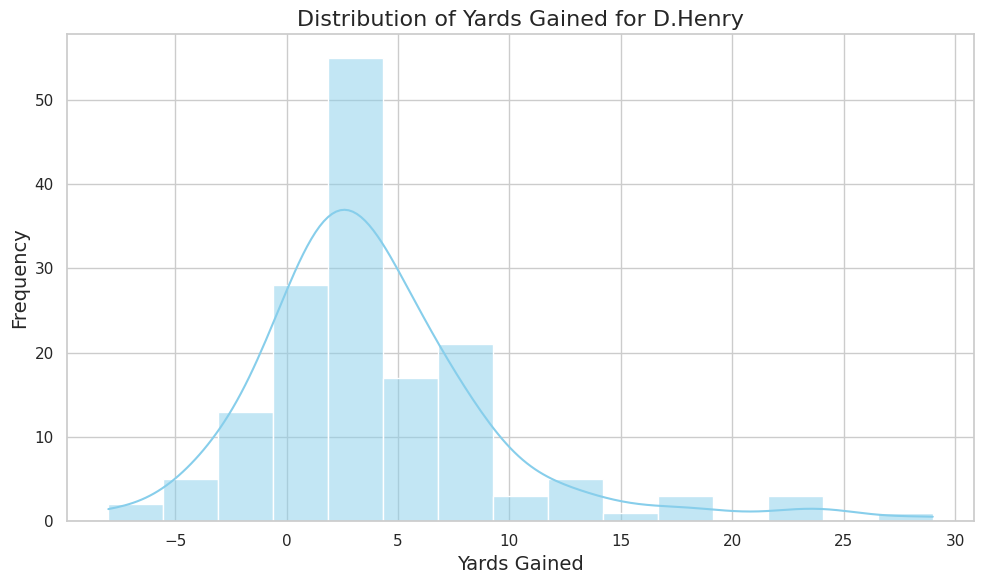

<Figure size 1400x700 with 0 Axes>

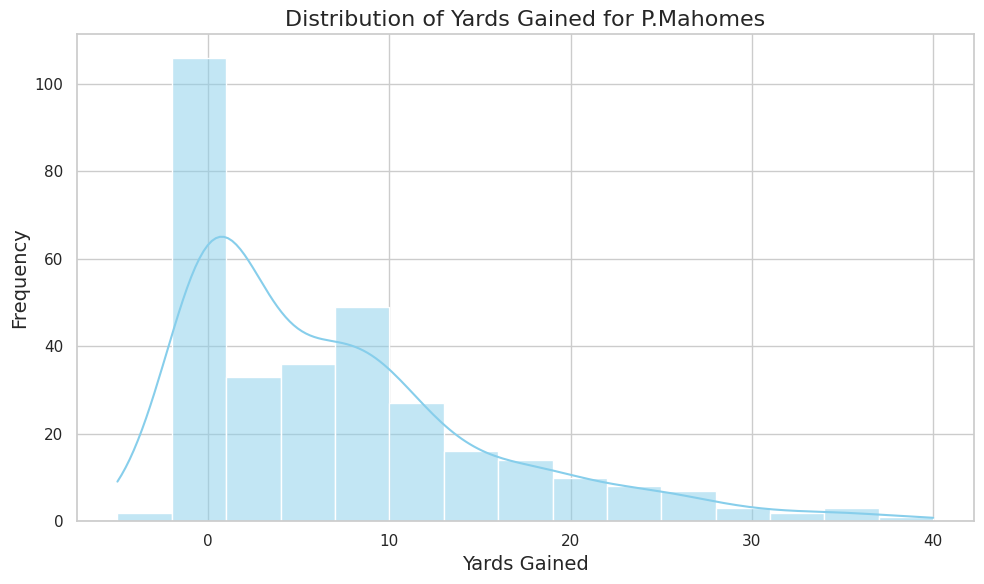

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#clear plot
plt.clf()

#plot yardsGained for designated player
def plot_yards_gained_for_player(df, player_name):
    """
    Plots the yards gained for a designated QB.

    Args:
        df (pd.DataFrame): The DataFrame containing play data.
        qb_name (str): The name of the QB to plot.

    Returns:
        None
    """
    # Filter plays for the designated QB or RB

    player_plays = df[(df["QB"] == player_name) | (df["RB"] == player_name)].copy()

    # Check if the QB exists in the DataFrame
    if player_plays.empty:
        print(f"No plays found for QB: {player_name}")
        return

    # Sort by 'playId' for chronological plotting
    player_plays = player_plays.sort_values(by="playId")

    # Optional: Reset index for plotting
    player_plays.reset_index(drop=True, inplace=True)

    # Plot Options
    plt.figure(figsize=(14, 7))

    # Additionally, plot a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(player_plays["yardsGained"], bins=15, kde=True, color="skyblue")
    plt.title(f"Distribution of Yards Gained for {player_name}", fontsize=16)
    plt.xlabel("Yards Gained", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_yards_gained_for_player(results_df, "D.Henry")  # Replace with desired player
plot_yards_gained_for_player(results_df, "P.Mahomes")  # Replace with desired player

In [ ]:
results_df['possessionTeamWinProb'] = results_df.apply(
    lambda row: row['preSnapHomeTeamWinProbability']
    if row['possessionTeam'] == row['homeTeamAbbr']
    else row['preSnapVisitorTeamWinProbability'],
    axis=1
)

In [ ]:
df = results_df

# Compute the Yards Gained Over Expected
df["yardsGainedOverExpected"] = df["yardsGained"] - df["xYardsGainedSportsBert"]

# Apply the scaling factor to Incomplete plays
df['weightedYardsGainedOverExpected'] = df.apply(
lambda row: row['scalingFactor'] * row['yardsGainedOverExpected'] if row['yardsGained'] == 0 else row['yardsGainedOverExpected'],
axis=1
)

11.004561184160156
-0.50185317
0.3634777272886546


In [ ]:
# Get QBs with more than 150 plays
qb_counts = df["QB"].value_counts()
high_play_qbs = qb_counts[qb_counts > 150].index.tolist()

# Get RBs with more than 60 plays
rb_counts = df["RB"].value_counts()
high_play_rbs = rb_counts[rb_counts > 60].index.tolist()

# Filter the DataFrame for these QBs and RBs
high_play_qbs_df = df[df["QB"].isin(high_play_qbs)]
high_play_rbs_df = df[df["RB"].isin(high_play_rbs)]

# Rank the unique QBs based on their average metrics and sort by weightedYardsGainedOverExpected
qb_rankings = (
    high_play_qbs_df.groupby("QB", as_index=False)[
        ["xYardsGainedSportsBert", "weightedYardsGainedOverExpected", "possessionTeamWinProb"]
    ]
    .mean()
    .sort_values(by="weightedYardsGainedOverExpected", ascending=False)
)

# Rank the unique RBs based on their average metrics and sort by weightedYardsGainedOverExpected
rb_rankings = (
    high_play_rbs_df.groupby("RB", as_index=False)[
        ["xYardsGainedSportsBert", "weightedYardsGainedOverExpected", "possessionTeamWinProb"]
    ]
    .mean()
    .sort_values(by="weightedYardsGainedOverExpected", ascending=False)
)

team_rankings = (
    results_df.groupby("possessionTeam", as_index=False)[
        ["xYardsGainedSportsBert", "weightedYardsGainedOverExpected", "possessionTeamWinProb"]
    ]
    .mean()
    .sort_values(by="weightedYardsGainedOverExpected", ascending=False)
)

# Print QB rankings
print("\nQB Rankings (Sorted by Weighted Yards Gained Over Expected):")
print(qb_rankings)

# Print RB rankings
print("\nRB Rankings (Sorted by Weighted Yards Gained Over Expected):")
print(rb_rankings)

#Print team rankings
print("\nTeam Rankings (Sorted by Weighted Yards Gained Over Expected):")
print(team_rankings)

# Print play counts for QBs and RBs
print("\nQB Play Counts (Players with >150 Plays):")
print(high_play_qbs_df["QB"].value_counts().sort_values(ascending=False))

print("\nRB Play Counts (Players with >60 Plays):")
print(high_play_rbs_df["RB"].value_counts().sort_values(ascending=False))




QB Rankings (Sorted by Weighted Yards Gained Over Expected):
              QB  xYardsGainedSportsBert  weightedYardsGainedOverExpected  \
22     P.Mahomes                6.323256                         1.536447   
20        M.Ryan                5.920541                         1.084570   
26  T.Tagovailoa                7.071624                         1.063367   
11   J.Garoppolo                7.115527                         1.022583   
14       J.Hurts                7.066553                         0.988482   
24       T.Brady                5.983183                         0.803006   
6        G.Smith                7.297031                         0.758883   
23      R.Wilson                6.424815                         0.733601   
9       J.Burrow                6.671313                         0.475645   
7        J.Allen                7.321786                         0.290211   
25    T.Lawrence                7.005378                         0.192733   
15     K.Cousi

In [1]:
#clear plot
plt.clf()

# Ensure the required DataFrame has correct columns for plotting
required_columns = {'possessionTeamWinProb', 'weightedYardsGainedOverExpected', 'QB'}
if not required_columns.issubset(qb_rankings.columns):
    raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(14, 10))
scatter_plot = sns.scatterplot(
    data=qb_rankings,
    x='possessionTeamWinProb',
    y='weightedYardsGainedOverExpected',
    palette='deep',
    hue='QB',
    s=100,  # Size of the markers
    edgecolor='w',
    alpha=0.7,
    legend=False
)

# Add a title and axis labels
plt.title('Weighted Yards Gained Over Expected vs. Average Current Team Win Probability', fontsize=18)
plt.xlabel('possessionTeamWinProb', fontsize=14)
plt.ylabel('Weighted Yards Gained Over Expected (Actual - xYards)', fontsize=14)

# Draw horizontal and vertical reference lines
plt.axhline(0, color='blue', linestyle='--', linewidth=1, label='')
plt.axvline(0.53, color='blue', linestyle='--', linewidth=1, label='')

# Annotate points with QB names, avoiding text overlap
for i, row in qb_rankings.iterrows():
    plt.text(
        row['possessionTeamWinProb'] + 0.005,  # Adjust x position for better visibility
        row['weightedYardsGainedOverExpected'] + 0.02,  # Adjust y position
        row['QB'],  # Text to display
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add background for better readability
    )


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'plt' is not defined

<Figure size 640x480 with 0 Axes>

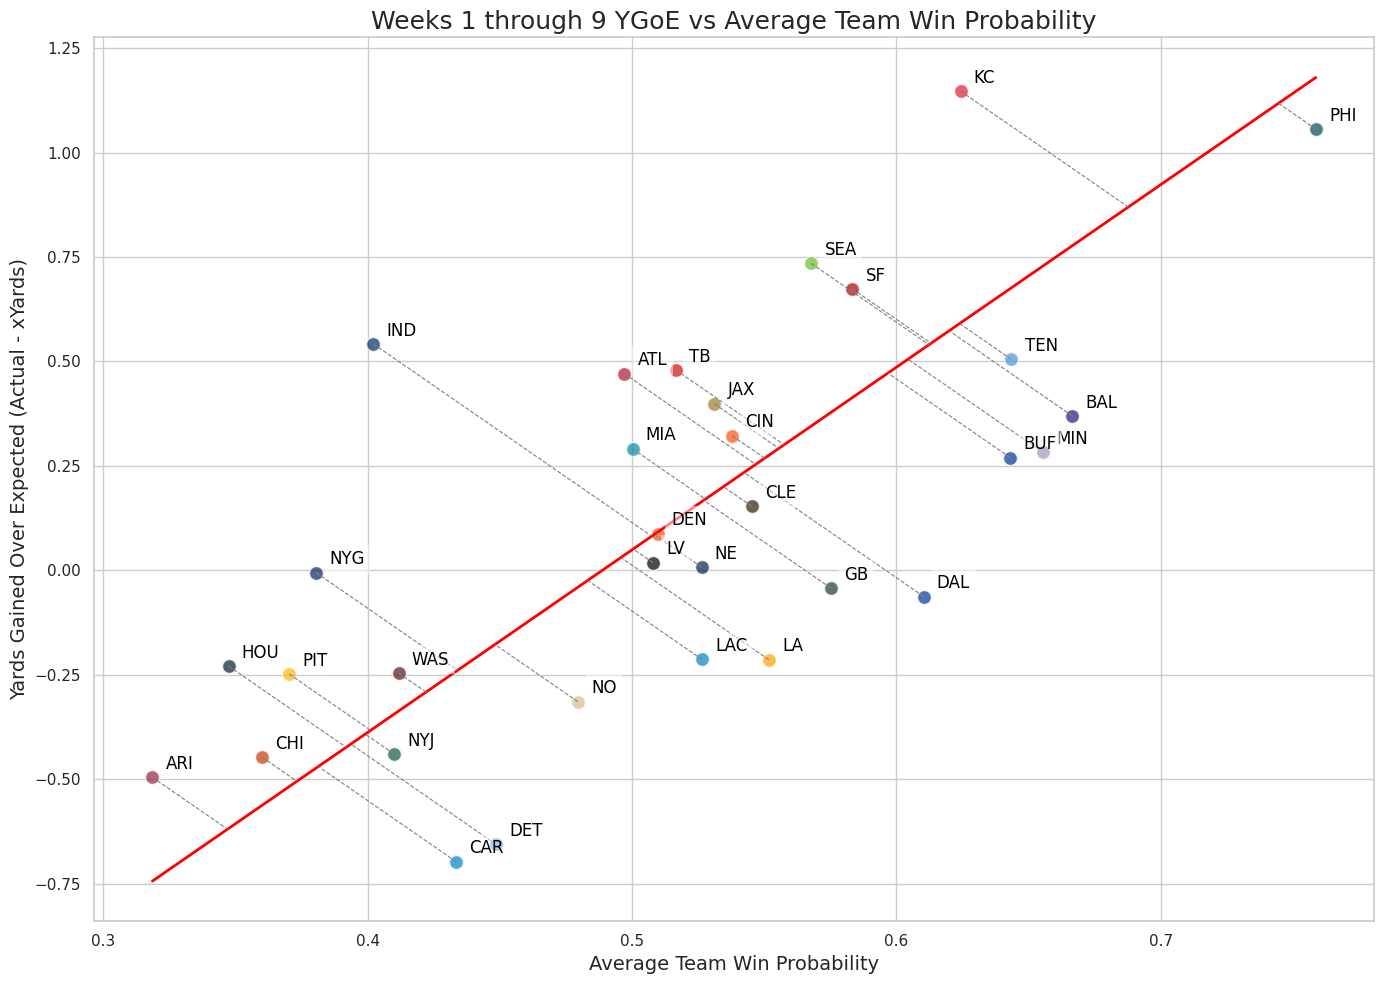

   possessionTeam  projection_value  rank
25            PHI          2.214749   1.0
15             KC          1.669553   2.0
30            TEN          1.056916   3.0
2             BAL          1.018936   4.0
28             SF          0.953482   5.0
27            SEA          0.945802   6.0
20            MIN          0.869857   7.0
3             BUF          0.796690   8.0
29             TB          0.419970   9.0
14            JAX          0.400896  10.0
6             CIN          0.349392  11.0
1             ATL          0.316611  12.0
8             DAL          0.274307  13.0
7             CLE          0.199526  14.0
19            MIA          0.134274  15.0
11             GB          0.128083  16.0
9             DEN         -0.042792  17.0
21             NE         -0.051378  18.0
13            IND         -0.060579  19.0
18             LV         -0.127936  20.0
16             LA         -0.172788  21.0
17            LAC         -0.293156  22.0
22             NO         -0.62970

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Clear any previous plots
plt.clf()

colors = {
    "ARI": "#97233F",
    "ATL": "#A71930",
    "BAL": "#241773",
    "BUF": "#00338D",
    "CAR": "#0085CA",
    "CHI": "#C83803",
    "CIN": "#FB4F14",
    "CLE": "#311D00",
    "DAL": "#003594",
    "DEN": "#FB4F14",
    "DET": "#0076B6",
    "GB": "#203731",
    "HOU": "#03202F",
    "IND": "#002C5F",
    "JAX": "#9F792C",
    "KC": "#E31837",
    "LA": "#FFA300",
    "LAC": "#0080C6",
    "LV": "#000000",
    "MIA": "#008E97",
    "MIN": "#4F2683",
    "NE": "#002244",
    "NO": "#D3BC8D",
    "NYG": "#0B2265",
    "NYJ": "#125740",
    "PHI": "#004C54",
    "PIT": "#FFB612",
    "SEA": "#69BE28",
    "SF": "#AA0000",
    "TB": "#D50A0A",
    "TEN": "#4B92DB",
    "WAS": "#5A1414",
}

# Ensure team colors are mapped correctly
team_rankings['color'] = team_rankings['possessionTeam'].map(colors)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(team_rankings[['possessionTeamWinProb', 'weightedYardsGainedOverExpected']])

# Function to project points onto the line y = x
def project_onto_line(x_point, y_point):
    """
    Project a point onto the line y = x in normalized space.
    Args:
        x_point (float): x-coordinate of the point
        y_point (float): y-coordinate of the point
    Returns:
        (float, float): coordinates of the projected point
        (float): projection value (distance along the line)
    """
    projection_value = (x_point + y_point) / 2
    projected_x = projection_value
    projected_y = projection_value
    return projected_x, projected_y, projection_value

# Compute projections for each point
projections = []
projection_values = []
for x_val, y_val in normalized_data:
    x_proj, y_proj, proj_val = project_onto_line(x_val, y_val)
    projections.append((x_proj, y_proj))
    projection_values.append(proj_val)

# Convert projections back to the original scale
projections = np.array(projections)
x_proj_original = scaler.inverse_transform(projections)[:, 0]
y_proj_original = scaler.inverse_transform(projections)[:, 1]

# Add projections and ranks to the DataFrame
team_rankings['x_projection'] = x_proj_original
team_rankings['y_projection'] = y_proj_original
team_rankings['projection_value'] = projection_values
team_rankings['rank'] = team_rankings['projection_value'].rank(ascending=False)

# Sort the DataFrame by rank
team_rankings = team_rankings.sort_values(by='rank')

# Plotting
plt.figure(figsize=(14, 10))

# Scatter plot of original points
for i, row in team_rankings.iterrows():
    plt.scatter(
        row['possessionTeamWinProb'],
        row['weightedYardsGainedOverExpected'],
        color=row['color'],
        s=100,
        edgecolor='w',
        alpha=0.7
    )

# Plot the line y = x in normalized space, then convert it to the original scale
x_vals = np.linspace(normalized_data[:, 0].min(), normalized_data[:, 0].max(), 100)
y_vals = x_vals
original_line = scaler.inverse_transform(np.column_stack((x_vals, y_vals)))

# Plot the line y = x
plt.plot(original_line[:, 0], original_line[:, 1], color='red', linestyle='-', linewidth=2, label='y = x')

# Plot projection lines
for i, row in team_rankings.iterrows():
    plt.plot(
        [row['possessionTeamWinProb'], row['x_projection']],
        [row['weightedYardsGainedOverExpected'], row['y_projection']],
        color='gray', linestyle='--', linewidth=0.8
    )

# Annotate points with team names
for i, row in team_rankings.iterrows():
    plt.text(
        row['possessionTeamWinProb'] + 0.005,
        row['weightedYardsGainedOverExpected'] + 0.02,
        row['possessionTeam'],
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Add title and labels
plt.title('Weeks 1 through 9 YGoE vs Average Team Win Probability', fontsize=18)
plt.xlabel('Average Team Win Probability', fontsize=14)
plt.ylabel('Yards Gained Over Expected (Actual - xYards)', fontsize=14)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print rankings
print(team_rankings[['possessionTeam', 'projection_value', 'rank']])


In [ ]:
#clear plot
plt.clf()
# Ensure the required DataFrame has correct columns for plotting
required_columns = {'possessionTeamWinProb', 'weightedYardsGainedOverExpected', 'RB'}
if not required_columns.issubset(rb_rankings.columns):
    raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(14, 10))
scatter_plot = sns.scatterplot(
    data=rb_rankings,
    x='xYardsGainedSportsBert',
    y='weightedYardsGainedOverExpected',
    palette='deep',
    hue='RB',
    s=100,  # Size of the markers
    edgecolor='w',
    alpha=0.7,
    legend=True
)

# Add a title and axis labels
plt.title('Weighted Yards Gained Over Expected vs. Expected Yards Gained', fontsize=18)
plt.xlabel('xYardsGained', fontsize=14)
plt.ylabel('Weighted Yards Gained Over Expected (Actual - Expected Yards)', fontsize=14)

# Draw horizontal and vertical reference lines
plt.axhline(0.5, color='blue', linestyle='--', linewidth=1, label='')
plt.axvline(4.2, color='blue', linestyle='--', linewidth=1, label='')

# Annotate points with QB names, avoiding text overlap
for i, row in rb_rankings.iterrows():
    plt.text(
        row['xYardsGainedSportsBert'] + 0.005,  # Adjust x position for better visibility
        row['weightedYardsGainedOverExpected'] + 0.02,  # Adjust y position
        row['RB'],  # Text to display
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add background for better readability
    )

# Adjust legend
plt.legend(
    title='Runningback',
    loc='lower right',  # Place the legend in the upper right of the plot
    frameon=True,       # Add a frame around the legend for clarity
    fontsize=10
)
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 640x480 with 0 Axes>

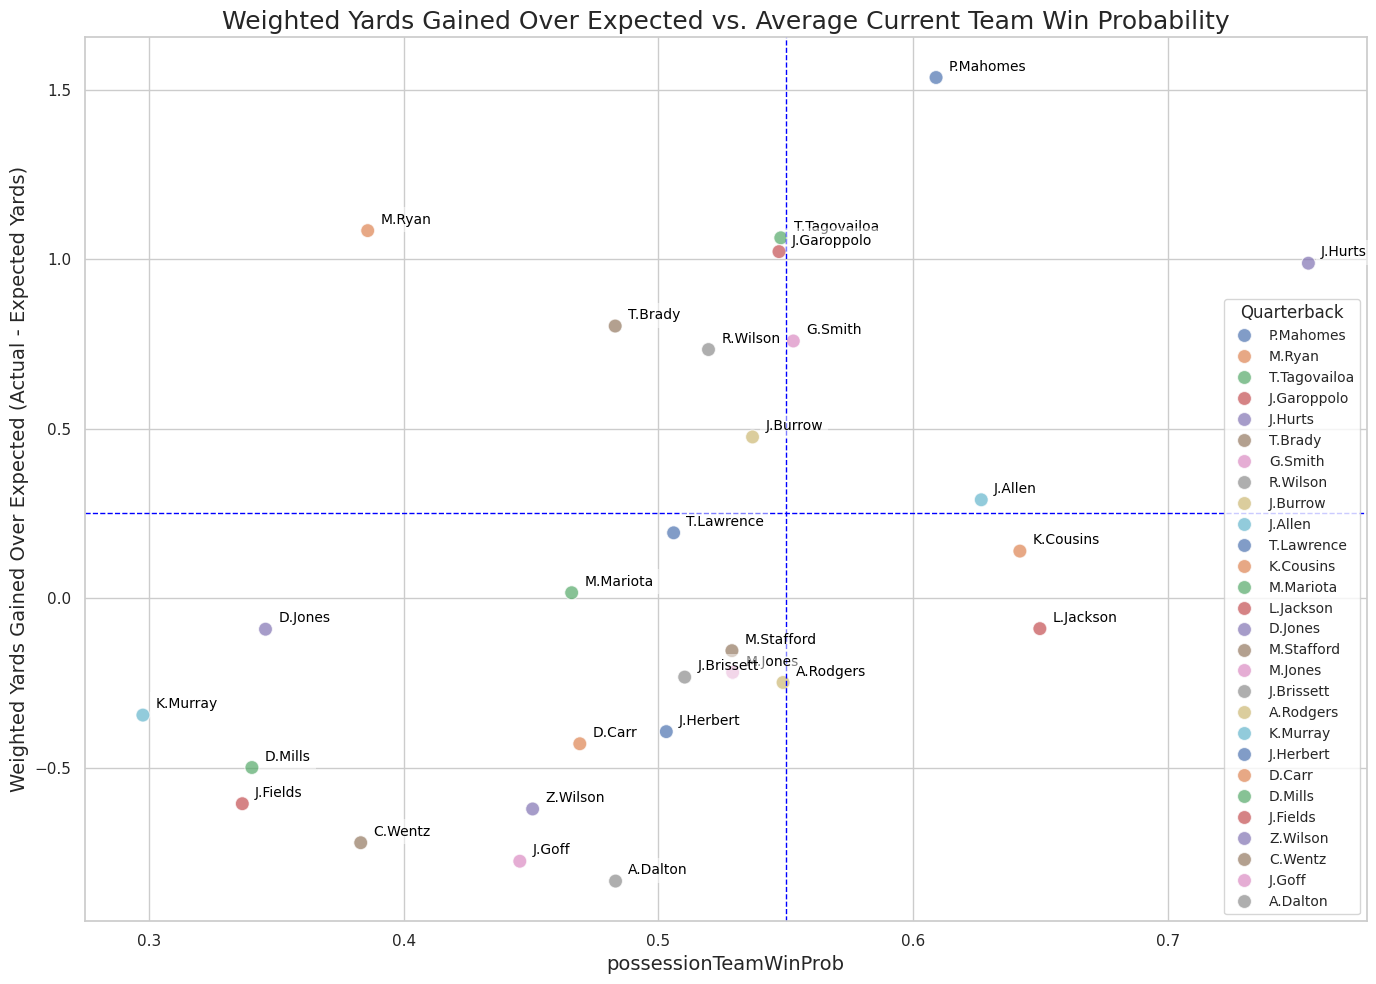

In [ ]:
#clear plot
plt.clf()
# Ensure the required DataFrame has correct columns for plotting
required_columns = {'possessionTeamWinProb', 'weightedYardsGainedOverExpected', 'QB'}
if not required_columns.issubset(qb_rankings.columns):
    raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(14, 10))
scatter_plot = sns.scatterplot(
    data=qb_rankings,
    x='possessionTeamWinProb',
    y='weightedYardsGainedOverExpected',
    palette='deep',
    hue='QB',
    s=100,  # Size of the markers
    edgecolor='w',
    alpha=0.7,
    legend=True
)

# Add a title and axis labels
plt.title('Weighted Yards Gained Over Expected vs. Average Current Team Win Probability', fontsize=18)
plt.xlabel('possessionTeamWinProb', fontsize=14)
plt.ylabel('Weighted Yards Gained Over Expected (Actual - Expected Yards)', fontsize=14)

# Draw horizontal and vertical reference lines
plt.axhline(0.25, color='blue', linestyle='--', linewidth=1, label='')
plt.axvline(0.55, color='blue', linestyle='--', linewidth=1, label='')

# Annotate points with QB names, avoiding text overlap
for i, row in qb_rankings.iterrows():
    plt.text(
        row['possessionTeamWinProb'] + 0.005,  # Adjust x position for better visibility
        row['weightedYardsGainedOverExpected'] + 0.02,  # Adjust y position
        row['QB'],  # Text to display
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add background for better readability
    )

# Adjust legend
plt.legend(
    title='Quarterback',
    loc='lower right',  # Place the legend in the upper right of the plot
    frameon=True,       # Add a frame around the legend for clarity
    fontsize=10
)
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import numpy as np

# Calculate MSE and RMSE
mse_sports = mean_squared_error(results_df["yardsGained"], results_df["xYardsGainedSportsBert"])
rmse_sports = np.sqrt(mse_sports)

mse_base = mean_squared_error(results_df["yardsGained"], results_df["xYardsGainedBase"])
rmse_base = np.sqrt(mse_base)

# Calculate Standard Deviation
std_sports_predictions = results_df["xYardsGainedSportsBert"].std()
std_actual_yards = results_df["yardsGained"].std()

std_base_predictions = results_df["xYardsGainedBase"].std()

# Print Metrics
print(f"SportsBERT MSE on Test Set: {mse_sports:.4f}")
print(f"SportsBERT RMSE on Test Set: {rmse_sports:.4f}")
print(f"SportsBERT Std Dev of Predictions: {std_sports_predictions:.4f}")
print(f"Std Dev of Actual Yards Gained: {std_actual_yards:.4f}")

print(f"Base Model MSE on Test Set: {mse_base:.4f}")
print(f"Base Model RMSE on Test Set: {rmse_base:.4f}")
print(f"Base Model Std Dev of Predictions: {std_base_predictions:.4f}")
print(f"Std Dev of Actual Yards Gained: {std_actual_yards:.4f}")

# Plot distribution of predictions
plt.figure(figsize=(10, 6))

# SportsBERT predictions
sns.histplot(results_df["xYardsGainedSportsBert"], bins=30, kde=True, color="blue", label="SportsBERT Predictions", alpha=0.7)

# Base model predictions
sns.histplot(results_df["xYardsGainedBase"], bins=30, kde=True, color="green", label="Base Model Predictions", alpha=0.7)

# Actual yards gained
sns.histplot(results_df["yardsGained"], bins=30, kde=True, color="orange", label="Actual Yards Gained", alpha=0.7)

# Plot formatting
plt.title("Distribution of Predictions vs. Actual Yards Gained", fontsize=16)
plt.xlabel("Yards Gained", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [ ]:
# Plot SportsBERT Predictions
plt.figure(figsize=(10, 6))
sns.histplot(results_df["xYardsGainedSportsBert"], bins=30, kde=True, color="blue", label="SportsBERT Predictions")
plt.title("Distribution of SportsBERT Predictions", fontsize=16)
plt.xlabel("Predicted Yards Gained", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Base Model Predictions
plt.figure(figsize=(10, 6))
sns.histplot(results_df["xYardsGainedBase"], bins=30, kde=True, color="green", label="Base Model Predictions")
plt.title("Distribution of Base Model Predictions", fontsize=16)
plt.xlabel("Predicted Yards Gained", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Actual Yards Gained
plt.figure(figsize=(10, 6))
sns.histplot(results_df["yardsGained"], bins=30, kde=True, color="orange", label="Actual Yards Gained")
plt.title("Distribution of Actual Yards Gained", fontsize=16)
plt.xlabel("Yards Gained", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Counter Factual Visualization


In [ ]:
# take the prompts in counter_factual_yards, extract

def extract_details_and_predictions(prompts, predictions):
    """
    Extract details from a list of play description prompts and add corresponding predictions.

    Args:
        prompts (list of str): List of play description prompts.
        predictions (list of float): List of predictions corresponding to each prompt.

    Returns:
        pd.DataFrame: DataFrame containing extracted details and predictions.
    """
    if len(prompts) != len(predictions):
        raise ValueError("The number of prompts must match the number of predictions.")

    # Define regex patterns
    patterns = {
        "quarter": r"It is (\d+) quarter",
        "game_clock": r"with ([\d:]+) left",
        "down": r"It is (\d+) down",
        "yards_to_first_down": r"with (\d+) yards to go",
        "yardline": r"The ball is on the [A-Z]+ (\d+) yardline",
        "play_call": r"The offense play call is a (.+)\."
    }

    # Storage for extracted details
    extracted_data = {key: [] for key in patterns.keys()}
    extracted_data["prediction"] = predictions  # Add predictions column

    for prompt in prompts:
        for key, pattern in patterns.items():
            match = re.search(pattern, prompt)
            if match:
                extracted_data[key].append(match.group(1))
            else:
                extracted_data[key].append(None)

    # Convert to DataFrame
    df = pd.DataFrame(extracted_data)

    # Calculate "yards to TD" based on field position (if available)
    def calculate_yards_to_td(yardline):
        if yardline is not None:
            yardline = int(yardline)
            return 100 - yardline if yardline <= 50 else yardline
        return None

    df['yards_to_td'] = df['yardline'].apply(lambda x: calculate_yards_to_td(x))
    df.drop(columns=['yardline'], inplace=True)  # Drop yardline column since it's no longer needed

    return df

# Example usage
prompts = [
    "Play 1: It is 1 quarter with 14:29 left. It is 2 down with 4 yards to go. The ball is on the BUF 31 yardline. The score is LA 0 - BUF 0. BUF have the ball. Current win probability for LA is 0.41 and for BUF it is 0.59. The offense is in empty formation with the receivers aligned in 3x2. The defense is in zone coverage with cover 6-left formation. The defense is rushing 0 cornerbacks, 0 safeties, 0 inside linebackers, 0 outside linebackers, 1 defensive ends, and 3 interior defensive linemen. The offense play call is a short inside box pass."
]

details_df = extract_details_and_predictions(counter_factual_prompts, counter_factual_yards_predictions)


In [ ]:
plays_to_keep = ['short inside box pass','zone run','deep outside box pass', 'power run', 'misdirection run']
details_df = details_df[details_df['play_call'].isin(plays_to_keep)]

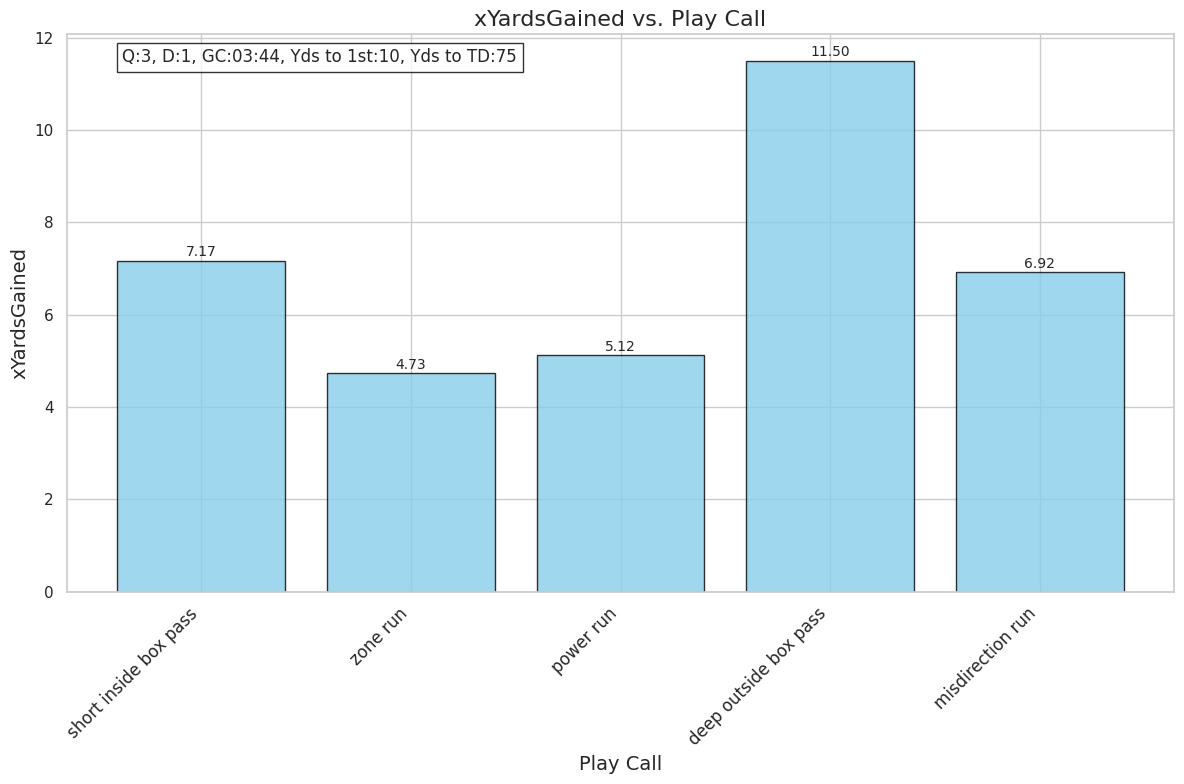

Play 13407: It is 3 quarter with 03:44 left. It is 1 down with 10 yards to go. The ball is on the LAC 25 yardline. The score is ATL 17 - LAC 14. LAC have the ball. Current win probability for ATL is 0.55 and for LAC it is 0.45. The offense is in singleback formation with the receivers aligned in 2x2. The defense is in zone coverage with cover-3 formation. The defense is rushing 0 cornerbacks, 0 safeties, 0 inside linebackers, 2 outside linebackers, 0 defensive ends, and 3 interior defensive linemen. The offense play call is a short inside box pass.


In [ ]:
def plot_predictions_vs_play_call_bar(df):
    """
    Creates a bar plot for predictions against play calls, with a single label displaying game context.

    Args:
        df (pd.DataFrame): DataFrame containing 'play_call', 'prediction', and game details ('quarter', 'down', 'game_clock').
    """
    # Ensure the DataFrame is sorted if necessary
    df = df.copy().reset_index(drop=True)

    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Create a bar plot
    bars = plt.bar(df['play_call'], df['prediction'], color='skyblue', edgecolor='black', alpha=0.8)

    # Add data labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', fontsize=10)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Add labels and title
    plt.title("xYardsGained vs. Play Call", fontsize=16)
    plt.xlabel("Play Call", fontsize=14)
    plt.ylabel("xYardsGained", fontsize=14)

    # Get the game context details (assuming all rows have the same context)
    first_row = df.iloc[0]
    game_context_label = (
        f"Q:{first_row['quarter']}, D:{first_row['down']}, "
        f"GC:{first_row['game_clock']}, Yds to 1st:{first_row['yards_to_first_down']}, "
        f"Yds to TD:{first_row['yards_to_td']}"
    )

    # Add the label to the plot as a text box in the corner
    plt.text(
        0.05, 0.95, game_context_label, fontsize=12, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage with your DataFrame 'details_df'
plot_predictions_vs_play_call_bar(details_df)
print(counter_factual_prompts[0])
